<a href="https://colab.research.google.com/github/wjSong61/Figure-for-literature-review/blob/main/Figure%20for%20literature%20review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import re
from collections import defaultdict, Counter
import plotly.graph_objects as go
import plotly.colors as pc

def generate_sankey_diagram(file_path, column_names, keyword_mappings, top_n=10,
                            title_text="Sankey Diagram", font_size=15, height=800):

    def split_and_clean(text):
        if pd.isna(text):
            return []
        return [re.sub(r'\s+', ' ', part.strip().lower())
                for part in re.split(r'[;,]', str(text)) if part.strip()]

    def create_mapper(mapping_dict):
        def mapper(text):
            text = text.lower()
            for category, keywords in mapping_dict.items():
                if any(kw in text for kw in keywords):
                    return category
            return text
        return mapper

    df = pd.read_excel(file_path)
    df.columns = [col.strip().lower() for col in df.columns]
    df = df[[col.lower() for col in column_names]]

    mappers = [create_mapper(keyword_mappings[col]) for col in column_names]
    paths = []
    method_counts = defaultdict(int)

    for _, row in df.iterrows():
        elements = [split_and_clean(row[col]) for col in column_names]
        mapped = [[mappers[i](item) for item in elements[i]] for i in range(3)]
        for a in mapped[0]:
            for b in mapped[1]:
                for c in mapped[2]:
                    paths.append((a, b, c))
                    method_counts[c] += 1

    top_methods = set([m for m, _ in sorted(method_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]])
    filtered_paths = [(a, b, c) for (a, b, c) in paths if c in top_methods]

    labels_0 = sorted({p[0] for p in filtered_paths})
    labels_1 = sorted({p[1] for p in filtered_paths})
    labels_2 = sorted({p[2] for p in filtered_paths})
    labels = labels_0 + labels_1 + labels_2

    label_to_index = {label: idx for idx, label in enumerate(labels)}
    link_counter = Counter()
    sensor_colors = pc.qualitative.Set3
    sensor_color_dict = {s: sensor_colors[i % len(sensor_colors)] for i, s in enumerate(labels_1)}
    color_map = {}

    for a, b, c in filtered_paths:
        a_idx = label_to_index[a]
        b_idx = label_to_index[b]
        c_idx = label_to_index[c]

        link_counter[(a_idx, b_idx)] += 1
        link_counter[(b_idx, c_idx)] += 1
        color_map[(a_idx, b_idx)] = sensor_color_dict[b]
        color_map[(b_idx, c_idx)] = sensor_color_dict[b]

    source_list, target_list, value_list, link_colors = [], [], [], []
    for (src, tgt), val in link_counter.items():
        source_list.append(src)
        target_list.append(tgt)
        value_list.append(val)
        rgba = color_map[(src, tgt)].replace("rgb", "rgba").replace(")", ",0.6)")
        link_colors.append(rgba)

    fig = go.Figure(data=[go.Sankey(
        arrangement='snap',
        node=dict(
            pad=15,
            thickness=15,
            line=dict(color="black", width=0.5),
            label=labels,
            color="rgba(180,180,180,0.8)"
        ),
        link=dict(
            source=source_list,
            target=target_list,
            value=value_list,
            color=link_colors
        )
    )])

    fig.update_layout(title_text=title_text, font_size=font_size, height=height)
    fig.show()

In [4]:
file_path = "https://raw.githubusercontent.com/wjSong61/Figure-for-literature-review/main/Sankey%20data.xlsx"
column_names = ['building type', 'sensor type', 'method']
top_n = 10

keyword_mappings = {
    'building type': {
        'School building': ['school building'],
        'Office building': ['office building'],
        'Residential building': ['residential building'],
        'Public building': ['public space', 'public dataset', 'cinema', 'commercial building'],
        'Smart building': ['smart building'],
        'Laboratory': ['laboratory'],
        'General': ['general']
    },
    'sensor type': {
        'Environmental sensor': ['temperature', 'humidity', 'light', 'sound'],
        'Motion sensor': ['pir', 'motion sensor'],
        'WI-FI/Bluetooth': ['wi-fi', 'bluetooth', 'smart phone'],
        'VOC': ['voc'],
        'CO2': ['co2'],
        'Camera': ['camera', 'cctv'],
        'Thermal imager': ['thermal imager'],
        'Electricity': ['electricity'],
        'Other': ['ami', 'pm10', 'pm2.5', 'pm', 'depth sensor', 'rgb color sensors', 'distance sensor',
                  'plug loads', 'occupied data', 'door sensor', 'public dataset']
    },
    'method': {
        'ML model': ['rf', 'svm', 'knn', 'gb', 'xgboost', 'dt', 'cart', 'gbm', 'k', 'svc', 'svr',
                     'dbscan', 'dbt', 'gbr', 'glm', 'gnb', 'gp', 'gpr', 'nb', 'qlda', 'rbf', 'wknn',
                     'varx', 'vht', 'wpca', 'rmse', 'rss', 'scm'],
        'Classification model': ['characterization', 'lr', 'lda', 'classification', 'binary classification',
                                 'nominal classifier', 'regression algorithms', 'slfn classifier', 'softmax regression',
                                 'occ-stpn', 'ap'],
        'Deep learning': ['tdnn', 'u-net', 'ssd', 'cnn-lstm', 'deep learning', 'resnet-50', 'cnn', 'mlp',
                          'ann', 'fnn', 'mlpc', 'yolo', 'yolov5', 'lstm', 'transfer learning', 'faster r-cnn',
                          'elm', 'os-elm', 'nn', 'r-cnn', 'rnn', 'dcnn', 'genetic programming', 'ihmm',
                          'fmmse'],
        'HMM': ['hmm'],
        'Equation-based model': ['arx', 'mass balance equation', 'pde', 'ode', 'kalman filter',
                                 'dynamic physical models', 'bayesian probability theory'],
        'Signal-based': ['rssi', 'mac', 'uuid', 'time stamp'],
        'Other method': ['digital twin', 'computer vision', 'pi-prm', 'custom algorithm',
                         'niom', 'point shape algorithm', 'triangle shape algorithm',
                         'ens', 'slt', 'abfa']
    }
}

generate_sankey_diagram(
    file_path=file_path,
    column_names=column_names,
    keyword_mappings=keyword_mappings,
    top_n=top_n,
    title_text=f"Building Type → Sensor Type → Top {top_n} Methods (Colored by Sensor)",
    font_size=15,
    height=800
)

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
from matplotlib.colors import to_rgba

def plot_sensor_year_distribution(
    file_path,
    column_names=('year', 'sensor type'),
    rename_columns={'sensor type': 'Sensor', 'year': 'Year'},
    keyword_merge=None,
    category_col='Sensor',
    value_col='Year',
    tick_font=14,
    title_font=20,
    label_font=18,
    xlabel='Sensor Type',
    ylabel='Publication Year',
    ylim=(2000, 2030),
    titlename="Distribution of Publication Years by Sensor Type",
    figsize=(12, 8)
):
    # Load and prepare data
    df = pd.read_excel(file_path)
    df.columns = [col.strip().lower() for col in df.columns]
    df = df[[col.lower() for col in column_names]].dropna()
    df = df.rename(columns={k.lower(): v for k, v in rename_columns.items()})

    # Standardize and classify
    def standardize(text):
        return re.sub(r'\s+', ' ', text.strip().lower())

    sensor_mapping = {}
    for category, keywords in (keyword_merge or {}).items():
        for kw in keywords:
            sensor_mapping[standardize(kw)] = category

    records = []
    unmatched_keywords = set()

    for _, row in df.iterrows():
        val = row[value_col]
        items = re.split(r'[;,]', str(row[category_col]))
        for item in items:
            item_std = standardize(item)
            mapped = sensor_mapping.get(item_std)
            if mapped:
                records.append({value_col: val, category_col: mapped})
            else:
                unmatched_keywords.add(item_std)

    if unmatched_keywords:
        print("⚠️ Unclassified keywords ({} total):".format(len(unmatched_keywords)))
        for kw in sorted(unmatched_keywords):
            print(f"  - {kw}")

    df = pd.DataFrame(records)

    # Beautify long labels: auto-insert line breaks for multi-word labels
    def auto_multiline(label):
        tokens = re.split(r'[\s/_-]+', label)
        if len(tokens) >= 2:
            return re.sub(r'[\s/_-]+', '\n', label, count=1)
        return label

    df[category_col] = df[category_col].apply(auto_multiline)

    # Determine order based on median value_col
    category_order = df.groupby(category_col)[value_col].median().sort_values().index.tolist()
    df[category_col] = pd.Categorical(df[category_col], categories=category_order, ordered=True)

    # Plotting
    sns.set(style="whitegrid")
    base_palette = sns.color_palette("Spectral", n_colors=len(category_order))
    strong_palette = [to_rgba(c, alpha=1.0) for c in base_palette]

    plt.figure(figsize=figsize)

    sns.violinplot(
        data=df, x=category_col, y=value_col,
        hue=category_col, palette=strong_palette,
        inner=None, linewidth=1, legend=False
    )

    sns.boxplot(
        data=df, x=category_col, y=value_col,
        width=0.2,
        showcaps=True,
        boxprops={'facecolor': 'white', 'alpha': 0.7, 'edgecolor': 'black', "zorder": 10},
        showfliers=False,
        whiskerprops={'linewidth': 1.5},
        medianprops={'color': 'black', 'linewidth': 2},
        zorder=10
    )

    sns.stripplot(
        data=df, x=category_col, y=value_col,
        jitter=True, size=2, color='k', alpha=0.2
    )

    plt.xlabel(xlabel, fontsize=label_font, fontweight='bold')
    plt.ylabel(ylabel, fontsize=label_font, fontweight='bold')
    plt.xticks(rotation=0, fontsize=tick_font)
    plt.yticks(fontsize=tick_font)
    plt.ylim(*ylim)
    plt.grid(linestyle='--', alpha=0.7)
    plt.title(titlename, fontsize=title_font, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()


⚠️ Unclassified keywords (2 total):
  - occupied data
  - public dataset


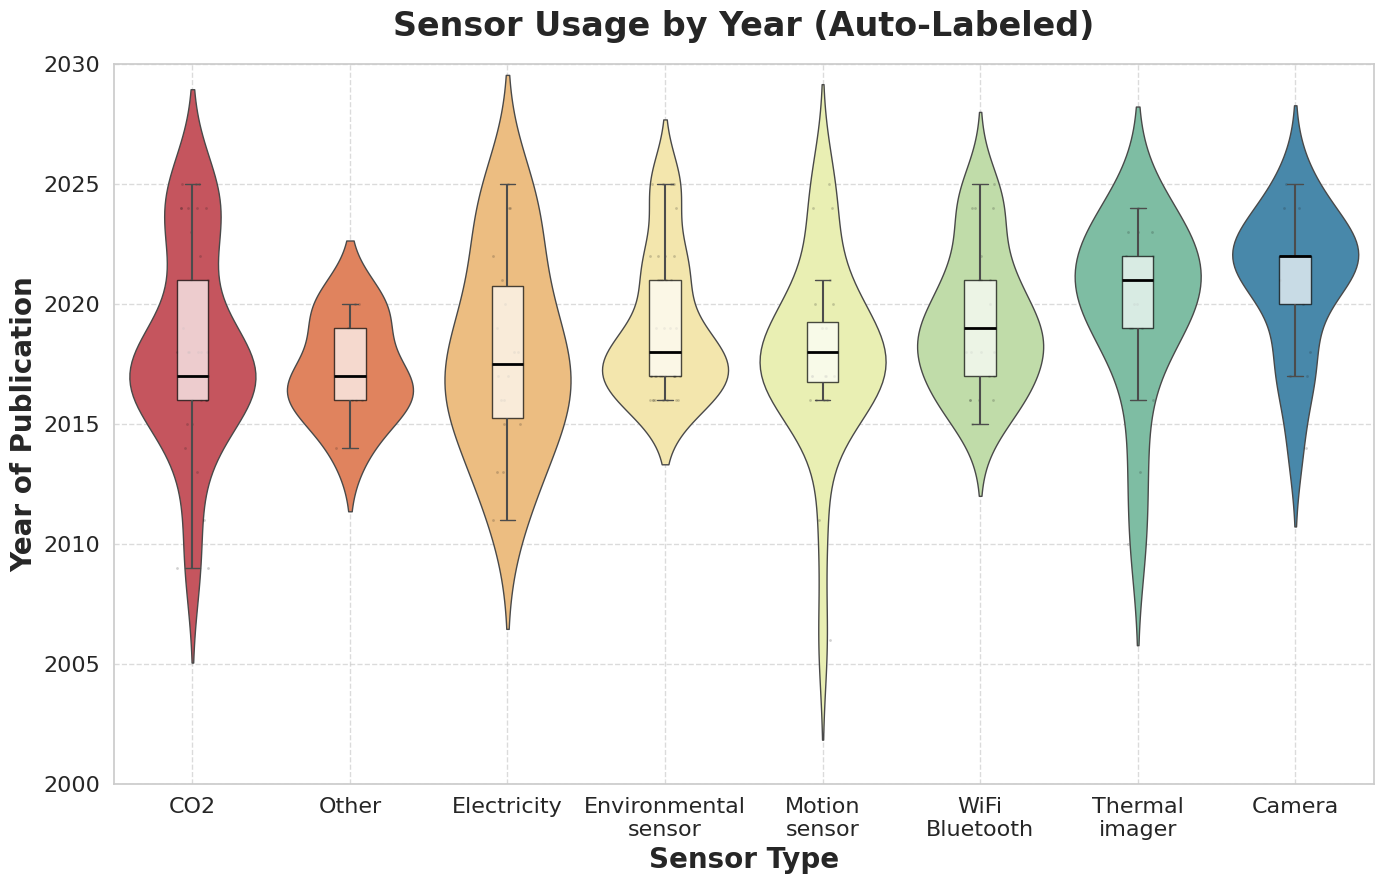

In [6]:
sensor_category_keywords = {
    'CO2': ['co2'],
    'Electricity': ['electricity', 'power consumption', 'plug load', 'smart meter'],
    'Motion sensor': ['pir', 'passive infrared', 'motion', 'motion sensor'],
    'Thermal imager': ['thermal imager', 'infrared', 'thermopile'],
    'Camera': ['camera', 'vision', 'cnn', 'yolo', 'rcnn', 'computer vision', 'cctv'],
    'WiFi/Bluetooth': ['wifi', 'bluetooth', 'ble', 'wi-fi', 'smart phone', 'plug loads'],
    'Environmental sensor': ['humidity', 'light', 'illuminance', 'temperature', 'co', 'pm', 'voc', 'sound', 'pm10', 'pm2.5'],
    'Other': ['ami', 'depth sensor', 'distance sensor', 'rgb color sensors', 'door sensor']
}

file_path = "https://raw.githubusercontent.com/wjSong61/Figure-for-literature-review/main/Sankey%20data.xlsx"

plot_sensor_year_distribution(
    file_path=file_path,
    column_names=('year', 'sensor type'),
    rename_columns={'year': 'Year', 'sensor type': 'Sensor'},
    keyword_merge=sensor_category_keywords,
    category_col='Sensor',
    value_col='Year',
    xlabel="Sensor Type",
    ylabel="Year of Publication",
    titlename="Sensor Usage by Year (Auto-Labeled)",
    tick_font=16,
    title_font=24,
    label_font=20,
    ylim=(2000, 2030),
    figsize=(14, 9)
)

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt

def plot_method_trends_by_year(
    file_path,
    category_keywords,
    columns=['year', 'method'],
    group_by_column='Year',
    category_column='Method Class',
    label_size=18,
    title_size=22,
    ticks_size=14,
    legend_size=14,
    figsize=(14, 8),
    ax1_ylabel="Trend (Lines)",
    title_name="Research Method Trends by Year",
    ax2_ylabel="Study Count (Stacked Bars)",
    xlabel="Year",
    legend_position=("upper left", (0.01, 0.99))  # (loc, bbox_to_anchor)
):
    # Set font
    plt.rcParams['font.family'] = 'Arial'

    # Load and standardize
    df = pd.read_excel(file_path)
    df.columns = [col.strip().lower() for col in df.columns]

    def standardize(text):
        return re.sub(r'\s+', ' ', text.strip().lower())

    method_mapping = {}
    for category, keywords in category_keywords.items():
        for kw in keywords:
            method_mapping[standardize(kw)] = category

    def split_and_clean(text):
        if pd.isna(text):
            return []
        return [re.sub(r'\s+', ' ', part.strip().lower()) for part in re.split(r'[;,]', str(text)) if part.strip()]

    def map_method(method):
        return method_mapping.get(method, 'Other/Uncategorized')

    # Extract records
    records = []
    uncategorized_methods = set()

    for _, row in df.iterrows():
        year = row[columns[0].lower()]
        methods = split_and_clean(row[columns[1].lower()])
        for m in methods:
            mapped = map_method(m)
            if mapped != 'Other/Uncategorized':
                records.append((year, mapped))
            else:
                uncategorized_methods.add(m)

    if uncategorized_methods:
        print("\n❗️Unclassified method keywords ({} total):".format(len(uncategorized_methods)))
        for m in sorted(uncategorized_methods):
            print(f"  - {m}")

    # Group data using parameterized columns
    df_grouped = pd.DataFrame(records, columns=[group_by_column, category_column])
    trend = df_grouped.groupby([group_by_column, category_column]).size().unstack(fill_value=0)
    trend.sort_index(inplace=True)

    # Plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True, gridspec_kw={'height_ratios': [1, 2]})
    colors = plt.cm.tab20.colors
    color_map = {}

    # Top line plot
    for i, col in enumerate(trend.columns):
        color = colors[i % len(colors)]
        ax1.plot(trend.index, trend[col], marker='o', label=col, color=color, linewidth=2)
        color_map[col] = color

    ax1.set_ylabel(ax1_ylabel, fontsize=label_size, fontweight='bold')
    ax1.set_title(title_name, fontsize=title_size, fontweight='bold')
    ax1.grid(True, linestyle='--', alpha=0.5)

    # Bottom stacked bar plot
    bottom = [0] * len(trend)
    for i, col in enumerate(trend.columns):
        ax2.bar(trend.index, trend[col], bottom=bottom, label=col, color=color_map[col], alpha=0.7)
        bottom = [sum(x) for x in zip(bottom, trend[col])]

    ax2.set_ylabel(ax2_ylabel, fontsize=label_size, fontweight='bold')
    ax2.set_xlabel(xlabel, fontsize=label_size, fontweight='bold')
    ax2.grid(True, linestyle='--', alpha=0.5)

    # Axis tick styling
    years = trend.index.tolist()
    ax2.set_xticks(years)
    ax2.set_xticklabels([str(int(y)) for y in years], fontsize=ticks_size)
    ax1.tick_params(axis='y', labelsize=ticks_size)
    ax2.tick_params(axis='y', labelsize=ticks_size)
    ax2.tick_params(axis='x', labelsize=ticks_size)

    # Legend
    loc, bbox = legend_position
    ax2.legend(
        title=category_column,
        loc=loc,
        bbox_to_anchor=bbox,
        fontsize=legend_size,
        title_fontsize=legend_size + 1,
        frameon=True
    )

    plt.tight_layout()
    plt.subplots_adjust(right=0.85)
    plt.show()


❗️Unclassified method keywords (30 total):
  - abfa
  - adr cycle
  - ap
  - cfam
  - csi
  - da-hoc++
  - energy simulation
  - ens
  - fmmse
  - geoma
  - gnm
  - imap
  - kinect face detection
  - l-gem
  - lcm
  - mod
  - mot
  - mot-lognn
  - niom
  - occ-stpn
  - pht
  - point shape algorithm
  - semi-supervised learning
  - slt
  - subpage bilinear interpolation method
  - supervised learning model
  - supervised machine learning
  - t-lognn
  - triangle shape algorithm
  - walksense


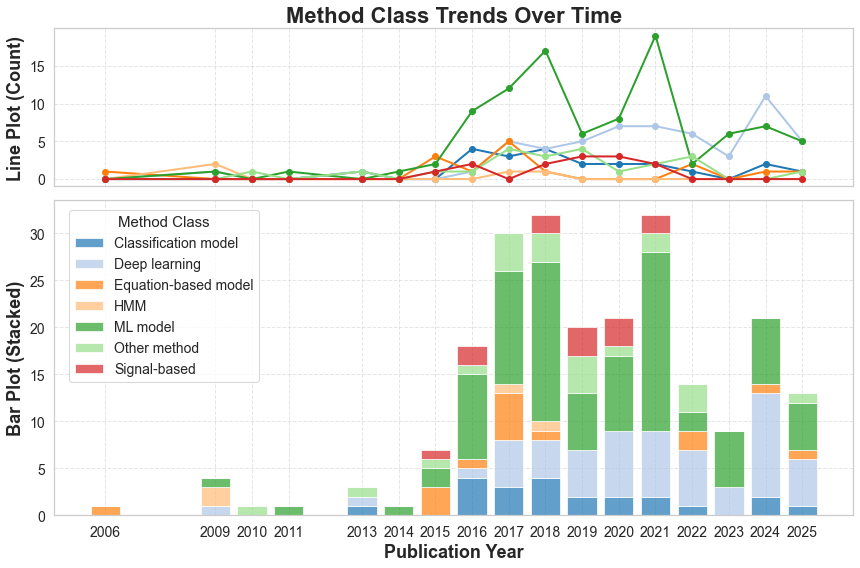

In [ ]:
category_keywords = {
    'ML model': ['rf', 'svm', 'knn', 'gb', 'xgboost', 'dt', 'cart', 'gbm', 'k', 'svc', 'svr', 'dbscan','dbt','gbr','glm','gnb','gp','gpr','nb','qlda','rbf','wknn','varx','vht','wpca','rmse','rss','scm'],
    'Classification model': ['characterization', 'lr', 'lda', 'classification', 'binary classification', 'nominal classifier', 'regression algorithms', 'slfn classifier', 'softmax regression'],
    'Deep learning': ['tdnn','u-net', 'ssd', 'cnn-lstm', 'deep learning', 'resnet-50', 'cnn', 'mlp', 'ann', 'fnn', 'mlpc', 'yolo', 'yolov5', 'lstm', 'transfer learning', 'faster r-cnn', 'elm', 'os-elm', 'nn', 'r-cnn', 'rnn', 'dcnn','genetic programming', 'ihmm'],
    'HMM': ['hmm'],
    'Equation-based model': ['arx', 'mass balance equation', 'pde', 'ode', 'kalman filter', 'dynamic physical models', 'bayesian probability theory'],
    'Signal-based': ['rssi', 'mac', 'uuid', 'time stamp'],
    'Other method': ['digital twin', 'computer vision', 'pi-prm', 'custom algorithm']
}

file_path = "https://raw.githubusercontent.com/wjSong61/Figure-for-literature-review/main/Sankey%20data.xlsx"

plot_method_trends_by_year(
    file_path=file_path,
    category_keywords=category_keywords,
    columns=['year', 'method'],
    group_by_column='Year',
    category_column='Method Class',
    title_name="Method Class Trends Over Time",
    ax1_ylabel="Line Plot (Count)",
    ax2_ylabel="Bar Plot (Stacked)",
    xlabel="Publication Year"
)

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

def plot_method_heatmap(
    file_path,
    keywords,
    columns=['year', 'method'],
    year_col='Year',
    method_col='Method',
    year_range=range(2015, 2026),
    top_n=12,
    figsize=(12, 9),
    cmap='YlGnBu',
    tick_font=20,
    label_font=24,
    title_font=26,
    legend_font=14,
    title='Top Methods Frequency by Year',
    xlabel='Year',
    ylabel='Method',
    annot=True,
    linewidths=0.5
):
    # Load and clean data
    df = pd.read_excel(file_path)
    df.columns = [col.strip().lower() for col in df.columns]

    def split_and_clean(text):
        if pd.isna(text):
            return []
        return [re.sub(r'\s+', ' ', part.strip().lower())
                for part in re.split(r'[;,]', str(text)) if part.strip()]

    keywords = [kw.lower() for kw in keywords]
    col_year = columns[0].lower()
    col_method = columns[1].lower()

    records = []
    for _, row in df.iterrows():
        year = row[col_year]
        methods = split_and_clean(row[col_method])
        for m in methods:
            if m in keywords:
                records.append((int(year), m))

    if not records:
        print("⚠️ No matching methods found.")
        return

    df_filtered = pd.DataFrame(records, columns=[year_col, method_col])

    # Top-N methods by frequency
    top_methods = (
        df_filtered[method_col]
        .value_counts()
        .nlargest(top_n)
        .index.tolist()
    )
    df_filtered = df_filtered[df_filtered[method_col].isin(top_methods)]

    # Filter by year range
    df_filtered = df_filtered[df_filtered[year_col].between(min(year_range), max(year_range))]

    # Pivot table
    heatmap_df = df_filtered.groupby([year_col, method_col]).size().unstack(fill_value=0)
    heatmap_df = heatmap_df.reindex(index=year_range, fill_value=0)

    # Order methods by total frequency
    method_order = heatmap_df.sum(axis=0).sort_values(ascending=False).index.tolist()
    heatmap_df = heatmap_df[method_order]

    # Plot
    plt.figure(figsize=figsize)
    ax = sns.heatmap(
        heatmap_df.T,
        cmap=cmap,
        linewidths=linewidths,
        annot=annot,
        fmt='g',
        annot_kws={'size': legend_font}
    )

    # Colorbar
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=legend_font)

    # Labels
    plt.title(title, fontsize=title_font, fontweight='bold', pad=20)
    plt.xlabel(xlabel, fontsize=label_font, fontweight='bold')
    plt.ylabel(ylabel, fontsize=label_font, fontweight='bold')
    plt.xticks(fontsize=tick_font)
    plt.yticks(rotation=0, fontsize=tick_font)
    plt.tight_layout()
    plt.show()


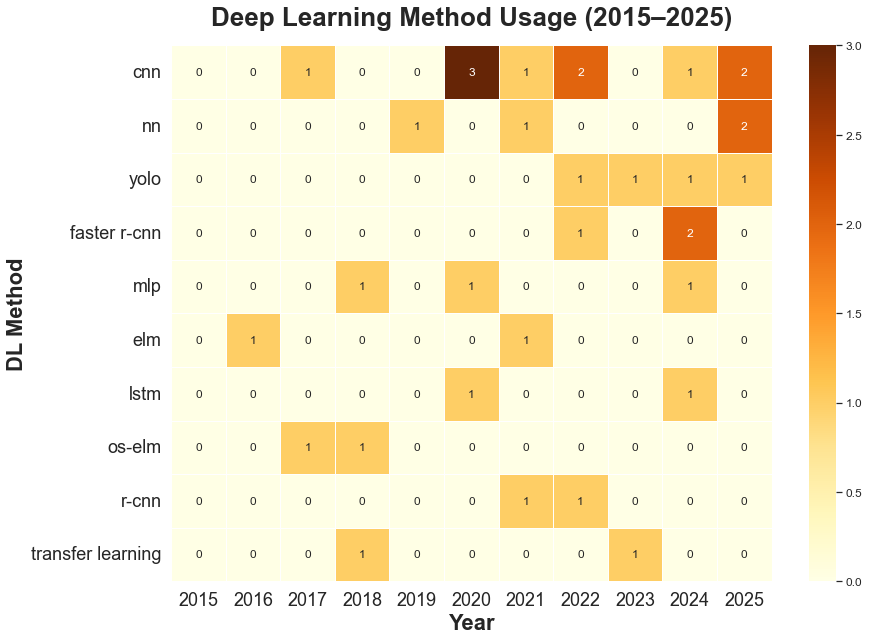

In [ ]:
dl_keywords = [
    'cnn', 'lstm', 'mlp', 'rnn', 'resnet-50', 'yolo', 'yolov5', 'faster r-cnn',
    'unet', 'tdnn', 'elm', 'dcnn', 'nn', 'r-cnn', 'os-elm', 'transfer learning'
]

file_path = "https://raw.githubusercontent.com/wjSong61/Figure-for-literature-review/main/Sankey%20data.xlsx"

plot_method_heatmap(
    file_path=file_path,
    keywords=dl_keywords,
    columns=['year', 'method'],
    year_col='Year',
    method_col='DL Method',
    year_range=range(2015, 2026),
    top_n=10,
    title="Deep Learning Method Usage (2015–2025)",
    xlabel="Year",
    ylabel="DL Method",
    tick_font=18,
    label_font=22,
    title_font=26,
    legend_font=12,
    figsize=(13, 9),
    cmap="YlOrBr"
)

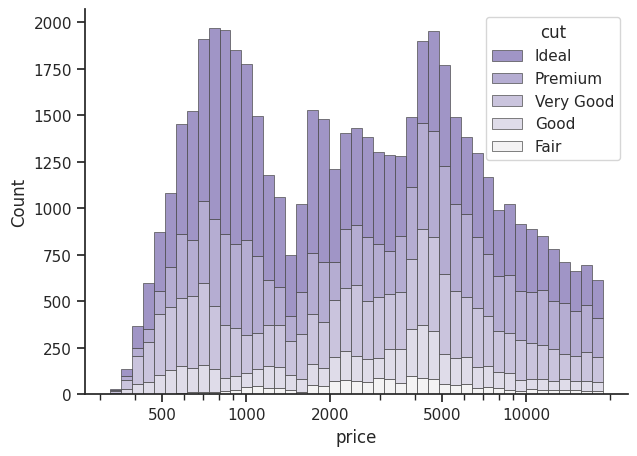

In [7]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

diamonds = sns.load_dataset("diamonds")

f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)

sns.histplot(
    diamonds,
    x="price", hue="cut",
    multiple="stack",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([500, 1000, 2000, 5000, 10000])

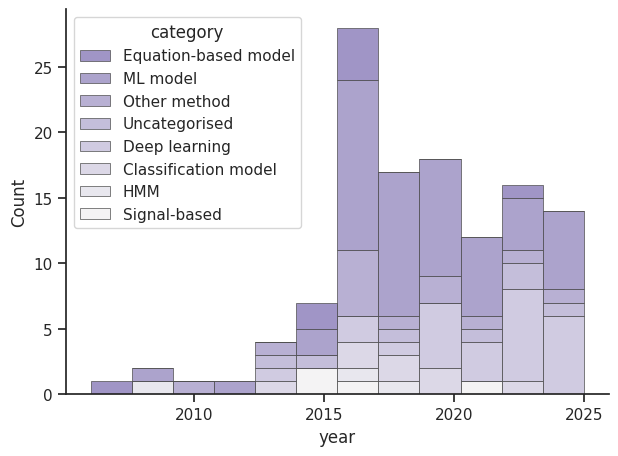

In [8]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker

sns.set_theme(style="ticks")

# diamonds = sns.load_dataset("diamonds")
file_path = "https://raw.githubusercontent.com/wjSong61/Figure-for-literature-review/main/Sankey%20data.xlsx"

df = pd.read_excel(file_path)    # Change to the file path
df.columns = [col.strip().lower() for col in df.columns]

category_keywords = {
    'ML model': ['rf', 'svm', 'knn', 'gb', 'xgboost', 'dt', 'cart', 'gbm', 'k', 'svc', 'svr', 'dbscan','dbt','gbr','glm','gnb','gp','gpr','nb','qlda','rbf','wknn','varx','vht','wpca','rmse','rss','scm'],
    'Classification model': ['characterization', 'lr', 'lda', 'classification', 'binary classification', 'nominal classifier', 'regression algorithms', 'slfn classifier', 'softmax regression'],
    'Deep learning': ['tdnn','u-net', 'ssd', 'cnn-lstm', 'deep learning', 'resnet-50', 'cnn', 'mlp', 'ann', 'fnn', 'mlpc', 'yolo', 'yolov5', 'lstm', 'transfer learning', 'faster r-cnn', 'elm', 'os-elm', 'nn', 'r-cnn', 'rnn', 'dcnn','genetic programming', 'ihmm'],
    'HMM': ['hmm'],
    'Equation-based model': ['arx', 'mass balance equation', 'pde', 'ode', 'kalman filter', 'dynamic physical models', 'bayesian probability theory'],
    'Signal-based': ['rssi', 'mac', 'uuid', 'time stamp'],
    'Other method': ['digital twin', 'computer vision', 'pi-prm', 'custom algorithm']
}

# Classify func
def map_method_to_category(method_str):
    method_str = str(method_str).lower()
    for category, keywords in category_keywords.items():
        for keyword in keywords:
            if keyword in method_str:
                return category
    return 'Uncategorised'

# Deploy
df['category'] = df['method'].apply(map_method_to_category)

f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)

sns.histplot(
    df,
    x="year", hue="category",
    multiple="stack", # layer, dodge, fill, stack
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    # log_scale=True,
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, _: f'{int(x)}'))